In [1]:
# Imports
import pathlib
import csv
import os
import cv2

import random
import numpy as np
import tqdm
#from tqdm.auto import tqdm
from PIL import Image, ImageEnhance

#from IPython.display import display
import IPython
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
#import torch.optim as optim

#from torchvision.utils import make_grid
import torchvision.transforms as transforms
#from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import Lambda

print(torch.__version__)
print(torchvision.__version__)

2.3.1+cu118
0.18.1+cu118


In [2]:
# @markdown `shuffle-spli and dataset constructor`
def shuffle_and_split_data(X, y, seed, split_percent=0.2):
  """
  Helper function to shuffle and split data, yoinked from W1D3 tutorial

  Args:
    X: torch.tensor
      Input data
    y: torch.tensor
      Corresponding target variables
    seed: int
      Set seed for reproducibility

  Returns:
    X_test: torch.tensor
      Test data [20% of X]
    y_test: torch.tensor
      Labels corresponding to above mentioned test data
    X_train: torch.tensor
      Train data [80% of X]
    y_train: torch.tensor
      Labels corresponding to above mentioned train data
  """
  # Set seed for reproducibility
  torch.manual_seed(seed)
  # Number of samples
  N = X.shape[0]
  # Shuffle data
  shuffled_indices = torch.randperm(N)   # Get indices to shuffle data, could use torch.randperm
  X = X[shuffled_indices]
  y = y[shuffled_indices]

  # Split data into train/test
  test_size = int(split_percent * N)    # Assign test datset size using split_percent*100% of samples
  X_test = X[:test_size]
  y_test = y[:test_size]
  X_train = X[test_size:]
  y_train = y[test_size:]

  return X_test, y_test, X_train, y_train

In [3]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [4]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.
# NOTE: This is mostly a GPU free tutorial.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook.")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [5]:
# Corruption functions
def add_salt_and_pepper_noise(image):
    row, col, _ = image.shape
    number_of_pixels = random.randint(300, 10000)
    for _ in range(number_of_pixels):
        y_coord = random.randint(0, row - 1)
        x_coord = random.randint(0, col - 1)
        image[y_coord, x_coord] = 255
    number_of_pixels = random.randint(300, 10000)
    for _ in range(number_of_pixels):
        y_coord = random.randint(0, row - 1)
        x_coord = random.randint(0, col - 1)
        image[y_coord, x_coord] = 0
    return image

def add_pepper_noise(image):
    row, col, _ = image.shape
    number_of_pixels = random.randint(300, 10000)
    for _ in range(number_of_pixels):
        y_coord = random.randint(0, row - 1)
        x_coord = random.randint(0, col - 1)
        image[y_coord, x_coord] = 0
    return image

def add_salt_noise(image):
    row, col, _ = image.shape
    number_of_pixels = random.randint(300, 50000)
    for _ in range(number_of_pixels):
        y_coord = random.randint(0, row - 1)
        x_coord = random.randint(0, col - 1)
        image[y_coord, x_coord] = 255
    return image

def color_shift(image):
    img = np.array(image)
    h, w, c = img.shape
    rand_h = random.uniform(-0.2, 0.2)
    rand_s = random.uniform(0.8, 1.2)
    rand_v = random.uniform(0.8, 1.2)
    cs_matrix = np.array([[rand_h, .2, 0.4], [0, rand_s, .6], [0.7, 0, rand_v]])
    cs_matrix = np.clip(cs_matrix.astype(int), 0, 255)
    shifted = np.apply_along_axis(lambda a: cs_matrix.dot(a), 2, img)
    return Image.fromarray(shifted.astype(np.uint8))

def adjust_contrast(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    Y = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)[:, :, 0]
    min_val = np.min(Y)
    max_val = np.max(Y)
    brightness = (max_val + min_val) / 2
    contrast = (max_val - min_val) / (max_val + min_val)
    brightness = brightness
    contrast = random.uniform(0.2, 3)
    image2 = cv2.convertScaleAbs(image_rgb, alpha=contrast, beta=brightness)
    return image2

# Function to apply selected corruption
def apply_corruption(image, corruption_type):
    if corruption_type == 'salt_and_pepper':
        return add_salt_and_pepper_noise(image)
    elif corruption_type == 'pepper':
        return add_pepper_noise(image)
    elif corruption_type == 'salt':
        return add_salt_noise(image)
    elif corruption_type == 'color_shift':
        return color_shift(image)
    elif corruption_type == 'adjust_contrast':
        return adjust_contrast(image)
    else:
        return image

In [6]:
def get_datasets(images_pathfull, image_name_prefix, CSVlabels_pathfull, N_samples, percent_test, percent_valid, 
                 transform=None, corruption_type=None):
    """
    Helper function to get train, test, and validation datasets, do note that the images come out rescaled to [0,1]

    Args:
        images_pathfull: string
            path to the folder that includes all the images
        image_name_prefix: string
            the first part of the image name, with full filename being image_name_prefix+"INTEGER"+".png"
        CSVlabels_pathfull: string
            path to a .CSV file that includes all the labels
        N_samples: integer
            total number of samples to procure
        transform: torch.transform
            additional transformations to apply to images
        percent_test: float
            ratio of N_samples to be moved to test dataset, test dataset size is N_samples*percent_test
        percent_valid: float
            ratio of N_samples to be moved to valid dataset, valid dataset size is N_samples*percent_valid

    Returns:
        train_data: torch.TensorDataset
            train data, comes out shuffled, total number of samples = N_samples*(1-percent_test-percent_valid)
        test_data: torch.TensorDataset
            test data, comes out shuffled, total number of samples = N_samples*percent_test
        valid_data: torch.TensorDataset
            validation data, comes out shuffled, total number of samples = N_samples*percent_valid
    """
    #LABELS...
    #load the labels
    with open(CSVlabels_pathfull, newline='') as csvfile:
        CSVlabels = list(csv.reader(csvfile))
    assert len(CSVlabels) >= N_samples
    shuffled_indices = torch.randperm(int(len(CSVlabels)))[:N_samples]
    labels = [CSVlabels[i] for i in shuffled_indices]
    string_size = len(labels[0][0])
    np_labels = np.empty((1, string_size))
    for dat in labels:
        i = 0
        temp = np.empty((1, string_size))
        for char in dat[0]:
            score = 4 * (ord(char) - 96)
            if score == -256: score = -10
            temp[0, i] = score/104
            #temp[0, i] = score/10.4
            i += 1
        np_labels = np.vstack((np_labels, temp))
    np_labels = np_labels[1:, :]
    totensor_trans = transforms.ToTensor()
    y_tensor = totensor_trans(np_labels)[0].float()

    trans_to_img = transforms.PILToTensor()
    im = Image.open(os.path.join(images_pathfull, image_name_prefix + f"{shuffled_indices[0]+1}.png"))
    im_tensor = 1. - trans_to_img(im).float() / 255. #scaled outs
    #im_tensor = trans_to_img(im).float() #no scaling!
    #im_tensor = torch.unsqueeze(im_tensor, 0)  # Add batch dimension
    
    for i in shuffled_indices[1:]:
        im = Image.open(os.path.join(images_pathfull, image_name_prefix + f"{i+1}.png"))
        im_tensor = torch.cat((im_tensor, 1.-trans_to_img(im).float()/255. ),0) #scaled outs
        #im_tensor = torch.cat((im_tensor, trans_to_img(im).float() ),0) #no scaling!
    #apply additional transform is speficied
    if transform != None: im_tensor=transform(im_tensor)
    
    if corruption_type:
        corrupted_images = []
        for img in im_tensor:
            corrupted_image = apply_corruption(img.numpy().transpose(1, 2, 0), corruption_type)
            corrupted_images.append(trans_to_img(Image.fromarray(corrupted_image.astype(np.uint8))).float() / 255.)
        im_tensor = torch.stack(corrupted_images)

    #shuffle and split our data
    X_test,  y_test,  X_train, y_train = shuffle_and_split_data(X=im_tensor, y=y_tensor, seed=SEED, split_percent=percent_test)
    X_valid, y_valid, X_train, y_train = shuffle_and_split_data(X=X_train, y=y_train, seed=SEED, split_percent=percent_valid / (1 - percent_test))

    print(f"train: {X_train.shape} {y_train.shape}\n test: {X_test.shape} {y_test.shape}\n vlid: {X_valid.shape} {y_valid.shape}\n ")
    test_data = TensorDataset(X_test, y_test)
    train_data = TensorDataset(X_train, y_train)
    valid_data = TensorDataset(X_valid, y_valid)

    return train_data, test_data, valid_data

In [7]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


In [8]:
# Usage example

train_data, test_data, valid_data = get_datasets(
    images_pathfull="/home/workstation319/Desktop/python/NMA_codes_n_stuffs/project/datasets/ocr_dataset",
    image_name_prefix="",
    CSVlabels_pathfull="/home/workstation319/Desktop/python/NMA_codes_n_stuffs/project/datasets/ocr_dataset/labels2.csv",
    N_samples=int(7.5e3),
    percent_test=0.1,
    percent_valid=0.05,
    transform=None,
    corruption_type= None #"salt_and_pepper"  # Choose the corruption type here
)


# we should be able to use predefined torch dataloader:
batch_size = 512
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          drop_last=True,
                          shuffle=True,
                          worker_init_fn=seed_worker,
                          generator=g_seed
                          )
test_loader = DataLoader(test_data,
                          batch_size=int(len(test_data)/2),
                          drop_last=True,
                          shuffle=True,
                          worker_init_fn=seed_worker,
                          generator=g_seed
                          )
valid_loader = DataLoader(valid_data,
                          batch_size=int(len(valid_data)/2),
                          drop_last=True,
                          shuffle=True,
                          worker_init_fn=seed_worker,
                          generator=g_seed
                          )

train: torch.Size([6375, 56, 256]) torch.Size([6375, 10])
 test: torch.Size([750, 56, 256]) torch.Size([750, 10])
 vlid: torch.Size([375, 56, 256]) torch.Size([375, 10])
 


In [9]:
test_data

In [10]:
valid_loader

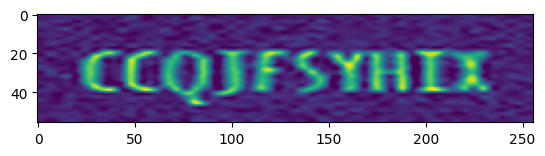

ccqjfsyhix



In [11]:
N=5
#img, label = next(iter(train_loader))
#img, label = next(iter(test_loader))
img, label = next(iter(valid_loader))
plt.imshow(img[N])
plt.show()
for a in label[N]:
    #print(a, end="")
    if a == -10/104:
        print(" ", end="")
    else:
        print(chr(int(a*104/4+96)), end="")
        #print(chr(int(a*10.4/4+96)), end="")
    #print(float(a))
print("\n")
#4 * (ord(char) - 96)

In [12]:
raise NotImplementedError("Halt before model")

NotImplementedError: Halt before model

In [13]:
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    from going_modular.going_modular import data_setup, engine

In [14]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(DEVICE)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
# set_seeds(42)
pretrained_vit.heads = nn.Linear(in_features=768, out_features=10).to(DEVICE)
# pretrained_vit # uncomment for model output

In [ ]:
# from torchsummary import summary
# summary(pretrained_vit, (1,3,224,224))

In [ ]:
# optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
#                              lr=1e-3)
# loss_fn = nn.MSELoss()

# # Train the classifier head of the pretrained ViT feature extractor model
# pretrained_vit_results = engine.train(model=pretrained_vit,
#                                       train_dataloader=train_loader,
#                                       test_dataloader=test_loader,
#                                       optimizer=optimizer,
#                                       loss_fn=loss_fn,
#                                       epochs=10,
#                                       device=DEVICE)


from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-2)
loss_f2 = nn.MSELoss()
loss_f1 = nn.L1Loss()

N_epochs = 40
resizing = transforms.Resize(size=(224,224))
epoch_loss = 0
epoch_valid_loss = 0
for epoch in tqdm.tqdm(range(N_epochs)):
    print(f" previous epoch loss = {epoch_loss}\n previous epoch valid loss = {epoch_valid_loss}")
    epoch_loss = 0
    epoch_valid_loss = 0
    # Train loop
    for batch in train_loader:
        images, labels = batch
        images = resizing( torch.unsqueeze(images, 0).permute(1, 0, 2, 3).expand(-1, 3, -1, -1) )
        #(B, C, H, W)
        #torch.Size([1, 128, 56, 256])    #print(images.shape)    #print(labels.dtype)    #print(images.dtype)
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        output = pretrained_vit(images)
        loss = 0.5*loss_f1(output, labels) + 0.5*loss_f1(output, labels)
        epoch_loss += loss.item()
        print(loss)
        loss.backward()
        optimizer.step()
    print("validation:")
    with torch.no_grad():
        for batch in valid_loader:
            images, labels = batch
            images = resizing( torch.unsqueeze(images, 0).permute(1, 0, 2, 3).expand(-1, 3, -1, -1) )
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            output = pretrained_vit(images)
            loss = 0.5*loss_f1(output, labels) + 0.5*loss_f1(output, labels)
            epoch_valid_loss += loss.item()
            print(loss)
    IPython.display.clear_output(wait=True)
    writer.add_scalar("Loss/train", epoch_loss, epoch)
    writer.add_scalar("Loss/valid", epoch_valid_loss, epoch)
writer.flush()

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 30/40 [37:56<12:41, 76.17s/it]

 previous epoch loss = 3.1877733170986176
 previous epoch valid loss = 0.5549135506153107
tensor(0.2686, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2741, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3042, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2600, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2668, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2851, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2540, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2635, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2762, device='cuda:0', grad_fn=<AddBackward0>)


In [ ]:
N=5
#img, label = next(iter(train_loader))
#img, label = next(iter(test_loader))
img, label = next(iter(test_loader))
plt.imshow(img[N])
plt.show()
for a in label[N]:
    #print(a, end="")
    if a == 0:
        print(" ", end="")
    else:
        print(chr(int(a*104/4+96)), end="")
    #print(float(a))
print("\n")
#4 * (ord(char) - 96)

In [ ]:
print(label[N])
with torch.no_grad():
    prediction = resnet( resizing( torch.unsqueeze(torch.unsqueeze(img[N], 0), 0).permute(1, 0, 2, 3).expand(-1, 3, -1, -1) ).to(DEVICE) )
prediction

In [ ]:
from going_modular.going_modular import engine